In [175]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold 
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
from itertools import permutations
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [160]:
workload_data = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')
labeled_data = pd.read_csv(index_col=0, filepath_or_buffer='labels.csv')

In [162]:
# Quick look at what we're working with
#print(workload_data.head())
unique = np.unique(labeled_data)
# Check how many labels there are
print(len(unique))
labeled_data_items = labeled_data.values.flatten()

# Inserting the labels into a dict for easy access
label_indices = dict()
for item in unique:
    indices = [idx for idx, label in enumerate(labeled_data_items) if item == label]
    label_indices[item] = indices







5


Q1.1 Task 1:
- Are there missing values? Look on their website of the data to see how missing values are coded
Answer: It says on the website that the missing values are "N/A", but there aren't any (which can be seen in the code below)
- Compute the means and variances of the features (visualise in a histogram or with a kernel density estimate). Do they vary widely?
Answer: They do vary quite a lot yes, however they bot vary in mean quite normally, and for variance quite logarithmic.
- Are there constant features?
Answer: There are 267 columns with a variance of 0 (where they are full of 0s) and 14944 columns with a variance of less than 2.

In [163]:
contains_missing_values = workload_data.isna()
columns_with_missing_values = 0
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        columns_with_missing_values += 0
print(f'Amount of columns with missing values: {columns_with_missing_values}')
means = workload_data.mean()

variances = workload_data.var()
n_of_constant_values = variances[variances == 0]
n_of_low_var_values = variances[variances < 2]
print(f'Number of columns with variance = 0: {len(n_of_constant_values)} st')
print(f'Number of columns with variance < 2: {len(n_of_low_var_values)} st')
print(f'Amount of columns that are completely full of 0s: {sum([1 for x in means if x == 0])}')
print(f'There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset')

Amount of columns with missing values: 0
Number of columns with variance = 0: 267 st
Number of columns with variance < 2: 14944 st
Amount of columns that are completely full of 0s: 267
There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset


In [164]:
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        print(f'{column_name=}')
print(f'No missing values, all gene_values are numeric values')
means = workload_data.mean()
variances = workload_data.var()
variance_threshold = 2
n_of_constant_values = variances[variances < variance_threshold]
print(f'Number of columns with variance < 2: {len(n_of_constant_values)} st')
print(f'There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset')

No missing values, all gene_values are numeric values
Number of columns with variance < 2: 14944 st
There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset


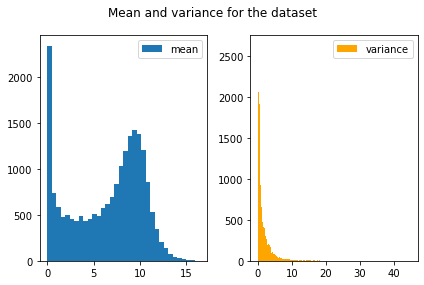

They do vary quite widely yes


In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do vary quite widely yes')

Q1.1 Task 2:

In [166]:
trimmed_data = workload_data.copy()
data_columns = trimmed_data.columns
selector = VarianceThreshold(threshold=variance_threshold)

# rename them with same index and column names
columns_data = [f'gene_{i}' for i in range(1, 5580)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
trimmed_data = pd.DataFrame(selector.fit_transform(trimmed_data), columns=columns_data, index=rows_data)

        

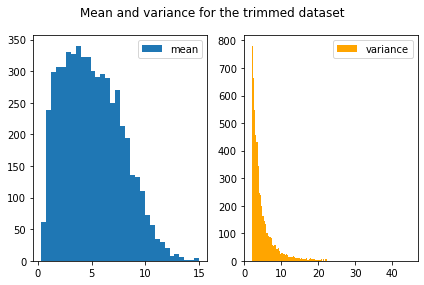

They do look alot better right now, gaussian and logarithmic


In [167]:
means = trimmed_data.mean()
variances = trimmed_data.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look alot better right now, gaussian and logarithmic')

-5.030693687977732e-17 0.9993755853277826


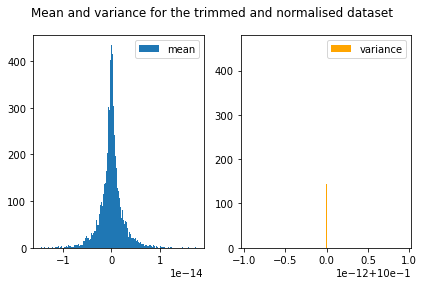

They do look very much "normalised", guess we will keep both and check


In [168]:
# Plot a normalised version to check if needed
normalized_df=(trimmed_data-trimmed_data.mean())/trimmed_data.std()
# Just checking it works
print(np.mean(np.mean(normalized_df)), np.mean(np.std(normalized_df)))

means = normalized_df.mean()
variances = normalized_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look very much "normalised", guess we will keep both and check')


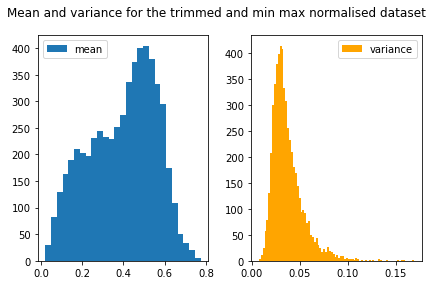

The min max version looks very similar to the original, might be an indication its not really needed


In [169]:
# Checking for max-min normalizing as well
min_max_df=(trimmed_data-trimmed_data.min())/(trimmed_data.max()-trimmed_data.min())

means = min_max_df.mean()
variances = min_max_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and min max normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'The min max version looks very similar to the original, might be an indication its not really needed')

In [170]:
n_components = 5
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)
print(principalComponents.shape)

(801, 5)


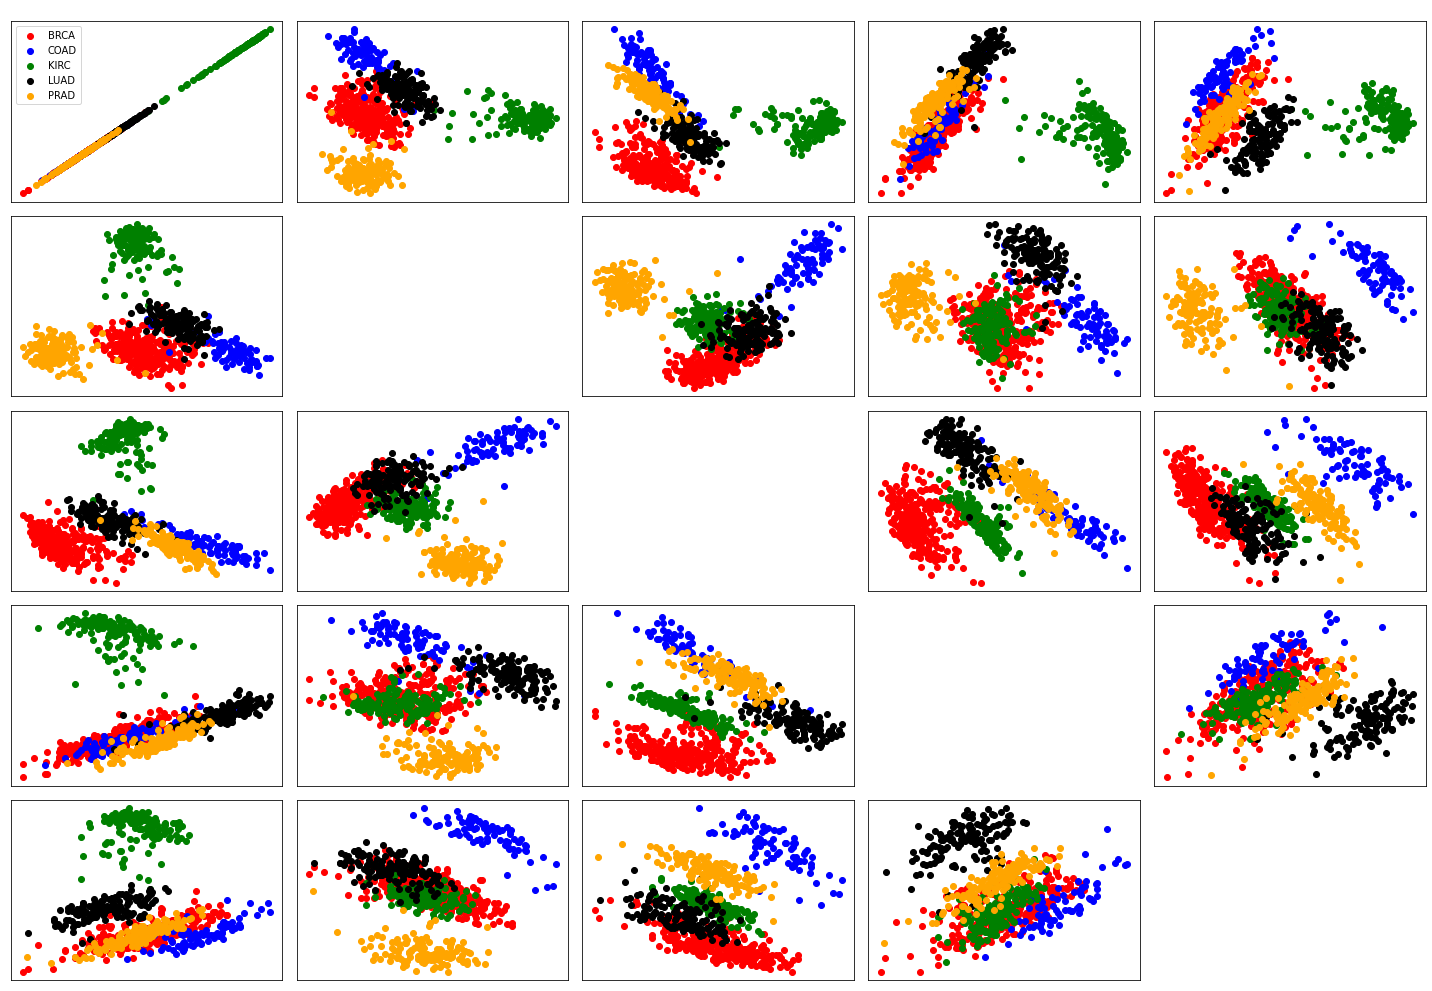

Here we can see that there are some clustered areas, up until about 5 there are some seperation, after that there is mostly just a blur


In [172]:

fig = plt.figure(figsize=(20,14))
plt.suptitle(f'{n_components} PCA analysis', color='White')
axes = fig.subplots(nrows=n_components, ncols=n_components)
colors = ['red', 'blue', 'green', 'black', 'orange']

for x_index in range(n_components):
    for y_index in range(n_components):
        for (label, value), color in zip(label_indices.items(), colors):
            if (x_index == y_index) and (x_index != 0):
                axes[x_index, y_index].set_axis_off()
            elif (x_index == 0 and y_index == 0):
                axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                axes[x_index, y_index].legend()
            else:
                axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color)
        axes[x_index, y_index].set_yticks(())
        axes[x_index, y_index].set_xticks(())
        #axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
        #axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')

plt.tight_layout()
plt.show()
print('Here we can see that there are some clustered areas, up until about 5 there are some seperation, after that there is mostly just a blur')

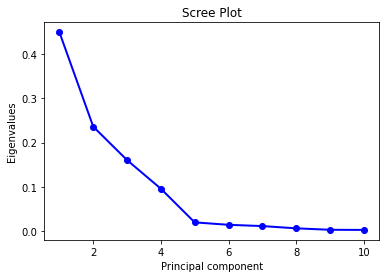

Not really sure what we're suppose to conclude here, HELP FREDRIK, guess there are 2 clear elbows at 2 and 5, 5 will probably be pretty good


In [145]:
# Doing the scree plot for 10 values 
n_components = 10
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)

PC_values = np.arange(pca.n_components) + 1
N = np.matrix(principalComponents.T)*np.matrix(principalComponents)
A, B, C = np.linalg.svd(N)
eigen_values = B**2/(np.sum(B**2))
plt.plot(PC_values, eigen_values, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()
print("Not really sure what we're suppose to conclude here, HELP FREDRIK, guess there are 2 clear elbows at 2 and 5, 5 will probably be pretty good")

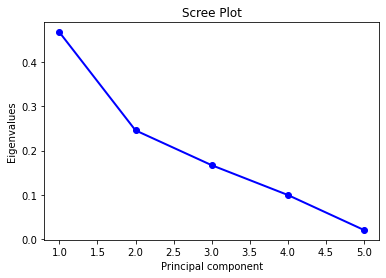

Not really right?


In [153]:
# Finally, check wather we can trim the PC-data further:
n_of_components = 5

pca = PCA(n_of_components)
principalComponents = pca.fit_transform(normalized_df)

PC_values = np.arange(pca.n_components) + 1
N = np.matrix(principalComponents.T)*np.matrix(principalComponents)
A, B, C = np.linalg.svd(N)
eigen_values = B**2/(np.sum(B**2))
plt.plot(PC_values, eigen_values, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()

print('Not really right?')

Q1.2 Task 4

In [184]:
n_components = 5
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)

n_of_clusters = 5
KM_model = KMeans(n_clusters=n_of_clusters, random_state=0)
KM_model.fit(principalComponents)
prediction = KM_model.predict(principalComponents).tolist()


# Mapping the predicted labels indices to the correct order list
label_perms = list(permutations(unique))
best_pred_score = 0
for label_list in label_perms:
    prediction_copy = deepcopy(prediction)
    for idx, label in enumerate(label_list):
        for jdx, item in enumerate(prediction_copy):
            if item == idx:
                prediction_copy[jdx] = label
    
    pred_score = accuracy_score(labeled_data_items, prediction_copy)
    if pred_score > best_pred_score:
        correct_label_list = label_list
        best_pred_score = pred_score
        best_prediction_copy = prediction_copy

print(best_pred_score, correct_label_list)

# Just making sure
print(np.sum(np.array(best_prediction_copy) == labeled_data.values.flatten())/len(labeled_data))

0.9725343320848939 ('PRAD', 'BRCA', 'LUAD', 'KIRC', 'COAD')
0.9725343320848939


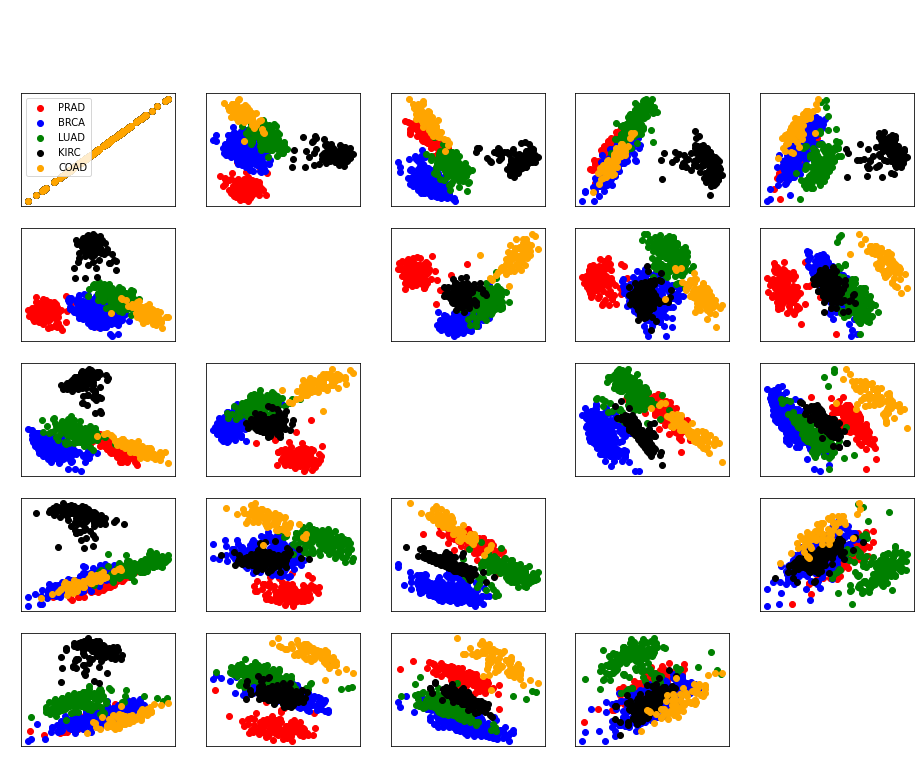

In [178]:


if n_components > 2:
    fig = plt.figure(figsize=(20,14))
    plt.suptitle(f'{n_components=} KM Clustering ', color='White')
    axes = fig.subplots(nrows=n_components, ncols=n_components)

    for x_index in range(n_components):
        for y_index in range(n_components):
            for cluster, color, label in zip(range(n_of_clusters), colors, correct_label_list):
                cluster_indices = [idx for idx, label in enumerate(prediction) if cluster == label]
                if x_index==y_index and x_index == 0:
                    axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                    axes[x_index, y_index].legend()
                elif x_index == y_index:
                    axes[x_index, y_index].set_axis_off()


                else:
                    axes[x_index, y_index].scatter(principalComponents[cluster_indices, x_index], principalComponents[cluster_indices, y_index], color=color)
            axes[x_index, y_index].set_yticks(())
            axes[x_index, y_index].set_xticks(())
            axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
            axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')
    plt.show()
else:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
    y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = KM_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(principalComponents[:, 0], principalComponents[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = KM_model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the digits dataset (PCA-reduced data, dim 2)\n"
        "Centroids are marked with white cross", color='White' # <- Change this before turning in, otherwise this text wille be invisible (unless they run darkmode)
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
fig = plt.figure(figsize=(16,12))
plt.suptitle(f'{n_components=} KM Clustering ', color='White')
axes = fig.subplots(nrows=n_components, ncols=n_components)



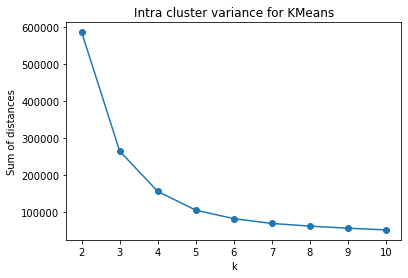

In [ ]:
# Calculate the intra cluster variance for a range of cluster sizes and plot them (disclose which PCA size we use)
n_of_runs = 10
cluster_sizes = range(2, 11)
variance_sizes = np.zeros(len(cluster_sizes))
for _ in range(n_of_runs):
    for i, n_of_clusters in enumerate(cluster_sizes):
        n_of_clusters = cluster_sizes[i]
        KM_model = KMeans(n_clusters=n_of_clusters)
        KM_model.fit(principalComponents)
        variance_sizes[i] += KM_model.inertia_

variance_sizes /= n_of_runs

plt.plot(cluster_sizes, variance_sizes, 'o-')
plt.title('Intra cluster variance for KMeans')
plt.ylabel('Sum of distances')
plt.xlabel('k')
plt.show()

In [186]:
n_of_clusters = 5
GM_model = GaussianMixture(n_components=n_of_clusters, random_state=0)
GM_model.fit(principalComponents)
prediction = GM_model.predict(principalComponents).tolist()

# Mapping the predicted labels indices to the correct order list
label_perms = list(permutations(unique))
best_pred_score = 0
for label_list in label_perms:
    prediction_copy = deepcopy(prediction)
    for idx, label in enumerate(label_list):
        for jdx, item in enumerate(prediction_copy):
            if item == idx:
                prediction_copy[jdx] = label
    
    pred_score = accuracy_score(labeled_data_items, prediction_copy)
    if pred_score > best_pred_score:
        correct_label_list = label_list
        best_pred_score = pred_score
        best_prediction_copy = prediction_copy

print(best_pred_score, correct_label_list)

# Just making sure
print(np.sum(np.array(best_prediction_copy) == labeled_data.values.flatten())/len(labeled_data))

0.9962546816479401 ('PRAD', 'BRCA', 'LUAD', 'KIRC', 'COAD')
0.9962546816479401


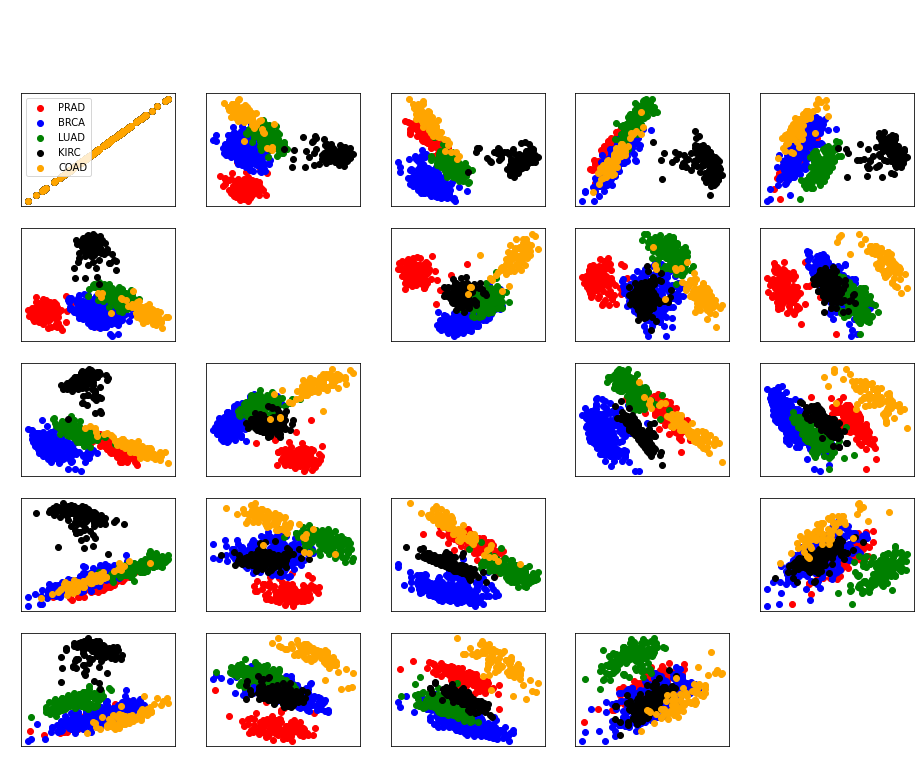

In [180]:
if n_components > 2:
    fig = plt.figure(figsize=(16,12))
    plt.suptitle(f'{n_components=} KM Clustering ', color='White')
    axes = fig.subplots(nrows=n_components, ncols=n_components)

    for x_index in range(n_components):
        for y_index in range(n_components):
            for cluster, color, label in zip(range(n_of_clusters), colors, correct_label_list):
                cluster_indices = [idx for idx, label in enumerate(prediction) if cluster == label]
                if x_index==y_index and x_index == 0:
                    axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                    axes[x_index, y_index].legend()
                elif x_index == y_index:
                    axes[x_index, y_index].set_axis_off()


                else:
                    axes[x_index, y_index].scatter(principalComponents[cluster_indices, x_index], principalComponents[cluster_indices, y_index], color=color)
            axes[x_index, y_index].set_yticks(())
            axes[x_index, y_index].set_xticks(())
            axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
            axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')
    plt.show()
else:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
    y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = GM_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(principalComponents[:, 0], principalComponents[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X

    plt.title(
        "GMM clustering on the digits dataset (PCA-reduced data, dim 2)\n"
        "Centroids are marked with white cross", color='White' # <- Change this before turning in, otherwise this text wille be invisible (unless they run darkmode)
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

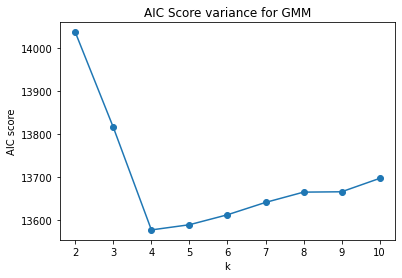

In [ ]:
# Calculate the intra cluster variance for a range of cluster sizes and plot them (disclose which PCA size we use)

cluster_sizes = range(2, 11)
variance_sizes = np.zeros(len(cluster_sizes))
for _ in range(n_of_runs):
    for i, n_of_clusters in enumerate(cluster_sizes):
        n_of_clusters = cluster_sizes[i]
        GM_model = GaussianMixture(n_components=n_of_clusters)
        GM_model.fit(principalComponents)
        variance_sizes[i] += GM_model.bic(principalComponents)
        
variance_sizes /= n_of_runs


plt.plot(cluster_sizes, variance_sizes, 'o-')
plt.title('AIC Score variance for GMM')
plt.ylabel('AIC score')
plt.xlabel('k')
plt.show()

MIGHT ALSO BE THAT WE NEED DIFFERENT CLUSTER SIZE ANALYSIS TOOLS BUT THAT WOULD JUST BE TO USE SOME DIFFERENT ONES (SIluotte, squared distances (which I have) and one more for KMEANS), (BIC, AIC and one more for GMM)